In [23]:
import os 
import keyring
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows') 

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

### WebBaseLoader로 웹페이지 내 텍스트를 vector DB로 저장하고 Retriever 만들기

In [24]:
# Store web contents into vector DB using WebBaseLoader and make it as a retriever
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(doc_list)

embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

# add to vectorDB
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

### 문서 관련성 검토 함수 정의하기

In [25]:
### Define retrieval grader

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
    
# LLM with function call
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

### 답변 작성 Chain 정의하기

In [26]:
# Define a chain for answering a question
### Generate
from langchain import hub 
from langchain_core.output_parsers import StrOutputParser

# prompt
prompt = hub.pull('rlm/rag-prompt')

# LLM
llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

# post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# chain
rag_chain = prompt | llm | StrOutputParser()

d:\projects\github\learning\llm\agent\agent\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### 질문 재작성 Chain 정의하기

In [27]:
# Define a question re-writer

question = 'agent memory'

# LLM
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Prompt
system = """You are re-writer that converts an input to a better version that is optimized \n
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            'human',
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        )
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is agent memory and how does it impact artificial intelligence performance?'

### 웹 검색 툴 설정

In [28]:
### Setting web search tool
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### GraphState 정의하기

In [29]:
# Define GraphSate
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """ 
    Represents the state of our graph.
    
    Attributes:
        question: quesion
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    
    question: str
    generation: str
    web_search: str
    documents: List[str]

### 위에서 정의한 Chain을 기반으로 노드 함수 정의하기

In [30]:
# define node function

from langchain.schema import Document

def retrieve(state):
    """ 
    Retrieve documents
    
    Args:
        state (dict) : The current graph state
    
    Returns:
        state (dict) : new key added to state, documents, that contains retrieved documents
    """
    
    print("---RETRIEVE---")
    question = state['question']
    
    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """ 
    Generate answer
    
    Args:
        state (dict) : The current graph state
    
    Returns:
        state (dict) : new key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state['question']
    documents = state['documents']
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """ 
    Determines whether the retrieved documents are relevant to the question.
    
    Args:
        state (dict) : the current graph state
    
    Returns:
        state (dict) : updates documents key with only filtered relevant documents
    """
    
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    documents = state['documents']
    
    # score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:       # if any irrelvant document
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = 'Yes'
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def transform_query(state):
    """ 
    Transform the query to produce a better question
    
    Args:
        state (dict): the current graph state
        
    Returns:
        state (dict): updates question key with a re-phrased question
    """
    
    print("---TRANSFORM QUERY---")
    question = state['question']
    documents = state['documents']
    
    # re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """ 
    Web search based on the re-phrased question
    
    Args:
        state (dict) : The current graph state
    Returns:
        state (dict) : updates documents key with appended web results
    """
    
    print("---WEB SEARCH---")
    question = state['question']
    documents = state['documents']
    
    # web search
    docs = web_search_tool.invoke({'query': question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents, "question": question}

### Edge
def decide_to_generate(state):
    """ 
    Determine whether to generate an answer, or re-generate a question.
    
    Args:
        state (dict) : the current graph state
        
    Returns:
        str: binary decision for next node to call
    """
    
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state['web_search']
    
    if web_search == "Yes":
        # All documents habe been filtered check_relevance
        # we will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESION, TRANSFORM QUERY---"
        )
        return "transform_query"
    
    else:
        # we have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return 'generate'

### 그래프 구축하기

In [31]:
# build graph

from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# define the nodes
workflow.add_node("retrieve", retrieve)     # retrieve
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

# build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    },
)

workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# compile
app = workflow.compile()

### 그래프 시각화

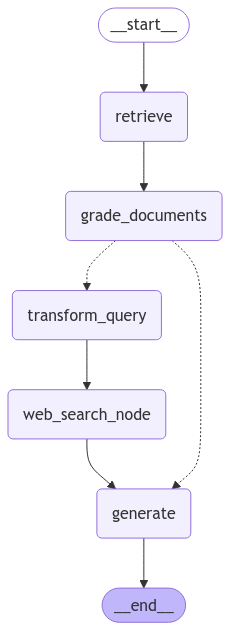

In [32]:
# PLOT GRAPH
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # this requires some extra dependencies and is optional
    pass

In [33]:
# run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}'")
        # optional : print full state at each node
        # pprint.pprint(value['keys'], indent=2, width=80, depth=None)
    print("\n---\n")
    
# final generation
print(value['generation'])

---RETRIEVE---
Node 'retrieve'

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESION, TRANSFORM QUERY---
Node 'grade_documents'

---

---TRANSFORM QUERY---
Node 'transform_query'

---

---WEB SEARCH---
Node 'web_search_node'

---

---GENERATE---
Node 'generate'

---

The different types of agent memory in artificial intelligence include short-term memory and long-term memory. Short-term memory is utilized for in-context learning, while long-term memory allows agents to retain and recall information over extended periods, often using external storage for retrieval. These memory types enhance the agent's ability to process information and adapt to new situations.
